In [907]:
import pandas as pd
import numpy as np
import nltk
from collections import defaultdict

### Import Scripts

In [908]:
episode_scripts_df = pd.read_csv("../05_Data/02_Clean/scripts_by_law_order_half.csv",index_col=0)
len(episode_scripts_df) #Number of Scripts should be 456

456

In [909]:
episode_scripts_df.head(3)

,season_ep,first,second
0,s01e01,Narrator In the criminal justice system the pe...,even know he was wrong You know now Nowwe have...
1,s01e02,Narrator In the criminal justice system the pe...,the screwdrivers We were going to rob some loc...
2,s01e03,Narrator In the criminal justice system the pe...,havent even thought of Logan The guys jive Im ...


### Truncate Script Half

Although the episodes are split in half between Law and Order, the cutoff may not be exactly at the 50% mark so this section allows you to toggle the section back if it helps with the clustering

In [910]:
def reduce_script(row,start,end):
    text = row.split()
    start_pos = int(len(text)*start)
    end_pos = int(len(text)*end)
    text = text[start_pos:end_pos]
    return " ".join(text)

In [911]:
episode_scripts_df["first"] = episode_scripts_df["first"].apply(reduce_script,start=0.15,end=.75)
episode_scripts_df.head()

,season_ep,first,second
0,s01e01,but it is not criminal Unless somebody was cri...,even know he was wrong You know now Nowwe have...
1,s01e02,leads on the gunman Gunwoman Gunperson A lot o...,the screwdrivers We were going to rob some loc...
2,s01e03,to himself a lot He didnt have a lot of friend...,havent even thought of Logan The guys jive Im ...
3,s01e04,they do drugs Sex is like a drink of water no ...,problem here He wasnt in custody He came volun...
4,s01e05,no place to raise a family anymore Just last w...,Mr Himes is a substantial member of the commun...


### Process Text for NLP

#### 1. Removing punctuation - Removed by the previous notebook (04_Clean_Scripts_by_Episode.ipynb) already
#### 2. Make Lowercase - Even though CountVectorizer and TFIDF already do this, why not do it manually here

In [912]:
episode_scripts_df["first"] = episode_scripts_df["first"].apply(lambda x: x.lower())
episode_scripts_df["first"][0][4500:4750]

'ything or there could be serious legal repercussions serious legal repercussions thats what we have here somebody used white out on suzanne mortons chart now on top of the white out it says acetaminophen a common everyday painkiller but underneath th'

#### 3. Remove Numbers

In [913]:
from string import digits
remove_digits = str.maketrans('', '', digits)
episode_scripts_df["first"] = episode_scripts_df["first"].apply(lambda x: x.translate(remove_digits))
episode_scripts_df["first"][0][4500:4750]

'ng or there could be serious legal repercussions serious legal repercussions thats what we have here somebody used white out on suzanne mortons chart now on top of the white out it says acetaminophen a common everyday painkiller but underneath the wh'

#### 4. Import Stopwords and  Remove Stopwords

In [914]:
law_order_stopwords = list(pd.read_csv("../05_Data/02_Clean/all_stopwords.csv",index_col=0)['0'])
law_order_stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [915]:
relationship_stopwords = ["mother","sister","father","brother","neighbord","cop","witness","customer","daughter",
                         "dad","attorney","baby","body","boyfriend","captain","clerk","cousin","fbi","girlfriend",
                         "killer","lady","lieutenant","men","nurse","officer","parent","person","shooter","victim",
                         "warrant","witness","judge","client","miss","mom","teacher","professor","student",
                         "child","childrens","employee","uncle","doctor","patient","owner", "driver",
                          "writer", "psychiatrist", "suspect","book","horse","dog","animal","chinese","drug"]

Combine Stopword Lists

In [916]:
law_order_stopwords = law_order_stopwords + relationship_stopwords

Remove Stopwords

In [917]:
from nltk.tokenize import word_tokenize

def remove_stopwords(row):
    tokens = word_tokenize(row)
    tokens_clean = [word for word in tokens if not word in law_order_stopwords] 
    text_clean = " ".join(tokens_clean)
    return text_clean.strip()

In [918]:
episode_scripts_df["first"] = episode_scripts_df["first"].apply(remove_stopwords)

In [919]:
episode_scripts_df["first"][0][4500:4750]

'er immigration morning strange time hiring time rounds night sometime stand around gabbing trying keep poor jerk bleeding death happened night rounds late waited chief medicine dr auster god high descending descended late said hed delayed retirement '

#### 5. Lemmatize Text

In [920]:
replace_dict = {"abused":"abuse", "adopted":"adoption", "bombing":"bomb", "fighting":"fight",
                "gangster":"gang","jew":"jewish","marriage":"married","medication":"medicine",
                "pregnancy":"pregnant","senate":"senator","shoot":"shooter","stabbed":"stab",
                "stabbing":"stab","suicidal":"suicide","russia":"russian","raped":"rape"}

In [921]:
from nltk.stem import WordNetLemmatizer

def lemma_my_text(row):
    tokens = word_tokenize(row)
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(y) for y in tokens]
    tokens_lemma = [x if x not in replace_dict else replace_dict[x] for x in tokens_lemma] #remap words in dict
    text_lemma = " ".join(tokens_lemma)
    return text_lemma.strip()

In [922]:
episode_scripts_df["first"] = episode_scripts_df["first"].apply(lemma_my_text)
episode_scripts_df["first"][0][2500:2750]

'n everyday painkiller underneath white said meperidine narcotic big difference rate cover whoever probably expecting investigation whoever wrote meperidine also wrote acetaminophen look e acetaminophen kind cursive penmanship style popular colony sha'

### Vectorize

In [923]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

I included stopwords again here in case the stemming process truncated variants of each stopword, they will be caught again here

In [924]:
vectorizer = TfidfVectorizer(ngram_range=(1,1),
                             stop_words=law_order_stopwords,
                             token_pattern="\\b[a-zA-Z][a-zA-Z][a-zA-Z]+\\b", #words with >= 3 alpha chars
                             max_df=.45,
                             min_df=.02) 
X = vectorizer.fit_transform(episode_scripts_df["first"])
X.shape

(456, 2855)

In [925]:
n_grams = list(vectorizer.get_feature_names())
counts = list(sum(X.toarray()))
word_counts = list(zip(n_grams, counts))
pd.DataFrame(word_counts).sort_values(by=1,ascending=False).head(5)

,0,1
1113,gun,15.918771
2157,school,13.285426
107,apartment,10.709691
344,building,10.242798
279,blood,9.752813


In [926]:
X_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
X_df.head()

,able,abortion,absolutely,abuse,academy,accent,accept,access,accessory,accident,...,yep,yesterday,yet,younger,youth,yup,yuppie,zero,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.056706,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.031282,0.0,0.0,0.000000,0.0,0.0,0.0,0.068675
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.060078,0.0,0.0,0.0,0.000000


### NMF Model

In [927]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=16)
nmf_vecs = nmf.fit_transform(X_df) 

In [928]:
len(nmf_vecs)

456

### Explore Topics

#### How many Episodes in each Topic? 

In [929]:
topic, episode_count = np.unique(nmf_vecs.argmax(axis = 1), return_counts=True)   # Num of eps in each topic
topic_count_df = pd.DataFrame(list(zip(topic,episode_count)))
topic_count_df = topic_count_df.drop([0],axis=1)
topic_count_df = topic_count_df.rename({1:"num_eps"},axis=1)
topic_count_df

,num_eps
0,46
1,42
2,16
3,40
4,26
5,46
6,42
7,31
8,13
9,23


#### Print Out Each Topic

In [930]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "Topic #%d: " % index
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, "\n")

In [931]:
words = list(X_df.columns.values)
print_top_words(model=nmf,feature_names=words,n_top_words=40)

Topic #0: bar club game aint drink great married actually story together partner movie world half stab knife bet read dude damn bookie gang fight either bitch meeting trouble square bottle live loved walk everybody funny regular thinking face ring stupid type 

Topic #1: gun shooting bullet slug dealer aint weapon ballistics trigger saint priest print serial open roof robbery permit dope easy millimeter wan match white everybody game glock scared fired black piece care possession maam window listen self clear clean sold face 

Topic #2: rape hospital evidence bruise reporter sex councilman without beat tape parole rapist drunk jury semen accident campus sample charge date priest hurt statement arrest dark moved lying report arrested true prosecute duty sexual press different investigation crap already worked missing 

Topic #3: bus white truck plate driving aint blue block unit drive garage black harlem side jewish spanish window corner neighborhood speaking vehicle missing bridge sir 

#### Visualize Topics

In [932]:
import matplotlib.pyplot as plt
eps_df = pd.DataFrame(nmf_vecs)

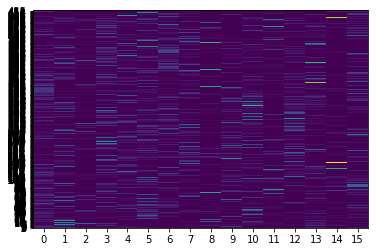

In [933]:
eps1_df = eps_df
plt.pcolor(eps1_df)
plt.yticks(np.arange(0.5, len(eps1_df.index), 1), eps1_df.index)
plt.xticks(np.arange(0.5, len(eps1_df.columns), 1), eps1_df.columns)
plt.show()

### Create Words in Topics DataFrame

In [934]:
def get_nmf_topics(model, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict[i] = words;
    
    return pd.DataFrame(word_dict).transpose();

In [935]:
topics_df = get_nmf_topics(model=nmf,num_topics=16)
topics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bar,club,game,aint,drink,great,married,actually,story,together,partner,movie,world,half,stab,knife,bet,read,dude,damn
1,gun,shooting,bullet,slug,dealer,aint,weapon,ballistics,trigger,saint,priest,print,serial,open,roof,robbery,permit,dope,easy,millimeter
2,rape,hospital,evidence,bruise,reporter,sex,councilman,without,beat,tape,parole,rapist,drunk,jury,semen,accident,campus,sample,charge,date
3,bus,white,truck,plate,driving,aint,blue,block,unit,drive,garage,black,harlem,side,jewish,spanish,window,corner,neighborhood,speaking
4,school,class,grade,high,test,library,blood,cell,hang,semester,yesterday,basketball,college,message,team,jacket,coach,lab,till,science
5,cancer,died,hospital,medical,death,clinic,suicide,blood,sick,die,medicine,autopsy,shed,poison,dying,insurance,therapy,care,food,pregnant
6,mail,letter,computer,photo,address,website,list,firm,information,cell,file,sent,threat,company,subpoena,security,lawsuit,email,complaint,death
7,hotel,restaurant,travel,agent,date,guest,garage,card,pregnant,dinner,met,staying,message,south,alone,cab,ticket,service,moved,movie
8,russian,plane,language,airport,flight,speaking,ticket,speak,dentist,motive,tourist,till,crazy,plan,bone,american,club,custom,carrying,market
9,party,boat,drink,senator,bus,prescription,argument,club,met,sir,jacket,model,pill,seeing,guest,camera,drunk,wearing,pant,weekend


### Create Topics in Episode DataFrame

Find Top Topic per Episode

In [936]:
max_topic = nmf_vecs.argmax(axis = 1)
topic_df = pd.DataFrame(max_topic)
topic_df = topic_df.rename({0:"topic"},axis=1)
topic_df.head()

,topic
0,5
1,1
2,13
3,9
4,1


Find Top Topic Score Per Episode

In [937]:
max_topic_score = nmf_vecs.max(axis = 1)
topic_score_df = pd.DataFrame(max_topic_score)
topic_score_df = topic_score_df.rename({0:"score"},axis=1)
topic_score_df.head()

,score
0,0.316450
1,0.117147
2,0.136869
3,0.148483
4,0.213549


Big Episode Topic Matrix

In [938]:
episode_topics_df = pd.DataFrame(nmf_vecs)
episode_topics_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.004828,0.000000,0.022824,0.009154,0.316450,0.003343,0.000000,0.000000,0.014423,0.000000,0.002525,0.000000,0.000000,0.0,0.000000
1,0.040947,0.117147,0.026128,0.020847,0.037297,0.023944,0.008812,0.000000,0.001245,0.000000,0.000000,0.016842,0.000000,0.052076,0.0,0.027333
2,0.025578,0.098967,0.001503,0.013431,0.093121,0.000000,0.000000,0.003430,0.000000,0.045636,0.002848,0.008999,0.029815,0.136869,0.0,0.000000
3,0.114739,0.000000,0.001157,0.000000,0.027437,0.004117,0.000000,0.018604,0.000000,0.148483,0.000000,0.000000,0.000000,0.000000,0.0,0.000237
4,0.011183,0.213549,0.005704,0.000000,0.000000,0.000000,0.000000,0.037914,0.000445,0.000000,0.000000,0.000000,0.164093,0.000000,0.0,0.000000


Merge Episode DataFrames Together

In [961]:
eps_topic_comb_df = episode_scripts_df.merge(topic_df,how='outer', left_index=True, right_index=True)
eps_topic_comb_df = eps_topic_comb_df.merge(topic_score_df,how='outer', left_index=True, right_index=True)
eps_topic_comb_df = eps_topic_comb_df.merge(episode_topics_df,how='outer', left_index=True, right_index=True)
eps_topic_comb_df = eps_topic_comb_df.drop(["first","second"],axis=1)
eps_topic_comb_df.head()

,season_ep,topic,score,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,s01e01,5,0.316450,0.000000,0.004828,0.000000,0.022824,0.009154,0.316450,0.003343,0.000000,0.000000,0.014423,0.000000,0.002525,0.000000,0.000000,0.0,0.000000
1,s01e02,1,0.117147,0.040947,0.117147,0.026128,0.020847,0.037297,0.023944,0.008812,0.000000,0.001245,0.000000,0.000000,0.016842,0.000000,0.052076,0.0,0.027333
2,s01e03,13,0.136869,0.025578,0.098967,0.001503,0.013431,0.093121,0.000000,0.000000,0.003430,0.000000,0.045636,0.002848,0.008999,0.029815,0.136869,0.0,0.000000
3,s01e04,9,0.148483,0.114739,0.000000,0.001157,0.000000,0.027437,0.004117,0.000000,0.018604,0.000000,0.148483,0.000000,0.000000,0.000000,0.000000,0.0,0.000237
4,s01e05,1,0.213549,0.011183,0.213549,0.005704,0.000000,0.000000,0.000000,0.000000,0.037914,0.000445,0.000000,0.000000,0.000000,0.164093,0.000000,0.0,0.000000


### Name Topics

In [964]:
top_eps_per_topic = eps_topic_comb_df.sort_values(['topic','score'],ascending=False)[["season_ep","topic","score"]].groupby('topic').head(5)

In [965]:
top_eps_per_topic[["season_ep","topic","score"]][top_eps_per_topic["topic"]==15]
#cycle through each time and look at scripts

,season_ep,topic,score
418,s19e08,15,0.424076
239,s11e11,15,0.327993
172,s08e16,15,0.308028
196,s09e16,15,0.298992
258,s12e06,15,0.279210


In [966]:
topic_dict = {0:"Bar/Drinking",1:"Shooting/Guns",2:"Sexual Assault",3:"Vehicle",4:"School",5:"Hospital",
              6:"Email/Phone/Mail",7:"Tourist/Visitor",8:"Russian Mob",9:"Party/Nightclub",10:"Apartment Building",
             11:"Bombing",12:"Credit Card Purchases",13:"Arson",14:"Money",15:"Romantic Relationship"}

In [967]:
topic_names_df = eps_topic_comb_df.rename(topic_dict,axis=1)
topic_names_df["topic"] = topic_names_df["topic"].map(topic_dict)

### Merge Topic Names with Episode Table & Export

In [968]:
topic_names_df.head()

,season_ep,topic,score,Bar/Drinking,Shooting/Guns,Sexual Assault,Vehicle,School,Hospital,Email/Phone/Mail,Tourist/Visitor,Russian Mob,Party/Nightclub,Apartment Building,Bombing,Credit Card Purchases,Arson,Money,Romantic Relationship
0,s01e01,Hospital,0.316450,0.000000,0.004828,0.000000,0.022824,0.009154,0.316450,0.003343,0.000000,0.000000,0.014423,0.000000,0.002525,0.000000,0.000000,0.0,0.000000
1,s01e02,Shooting/Guns,0.117147,0.040947,0.117147,0.026128,0.020847,0.037297,0.023944,0.008812,0.000000,0.001245,0.000000,0.000000,0.016842,0.000000,0.052076,0.0,0.027333
2,s01e03,Arson,0.136869,0.025578,0.098967,0.001503,0.013431,0.093121,0.000000,0.000000,0.003430,0.000000,0.045636,0.002848,0.008999,0.029815,0.136869,0.0,0.000000
3,s01e04,Party/Nightclub,0.148483,0.114739,0.000000,0.001157,0.000000,0.027437,0.004117,0.000000,0.018604,0.000000,0.148483,0.000000,0.000000,0.000000,0.000000,0.0,0.000237
4,s01e05,Shooting/Guns,0.213549,0.011183,0.213549,0.005704,0.000000,0.000000,0.000000,0.000000,0.037914,0.000445,0.000000,0.000000,0.000000,0.164093,0.000000,0.0,0.000000


In [969]:
topic_names_df.to_csv("../05_Data/04_Model_Output/1st_half_episodes_by_topic.csv")

### Merge Topic Names with Word Table & Export

In [970]:
topic_words_df = topic_count_df.merge(topics_df,how='outer', left_index=True, right_index=True)
topic_words_df = topic_words_df.rename(topic_dict,axis=0)
topic_words_df.head(10)

,num_eps,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
Bar/Drinking,46,bar,club,game,aint,drink,great,married,actually,story,...,partner,movie,world,half,stab,knife,bet,read,dude,damn
Shooting/Guns,42,gun,shooting,bullet,slug,dealer,aint,weapon,ballistics,trigger,...,priest,print,serial,open,roof,robbery,permit,dope,easy,millimeter
Sexual Assault,16,rape,hospital,evidence,bruise,reporter,sex,councilman,without,beat,...,parole,rapist,drunk,jury,semen,accident,campus,sample,charge,date
Vehicle,40,bus,white,truck,plate,driving,aint,blue,block,unit,...,garage,black,harlem,side,jewish,spanish,window,corner,neighborhood,speaking
School,26,school,class,grade,high,test,library,blood,cell,hang,...,yesterday,basketball,college,message,team,jacket,coach,lab,till,science
Hospital,46,cancer,died,hospital,medical,death,clinic,suicide,blood,sick,...,medicine,autopsy,shed,poison,dying,insurance,therapy,care,food,pregnant
Email/Phone/Mail,42,mail,letter,computer,photo,address,website,list,firm,information,...,file,sent,threat,company,subpoena,security,lawsuit,email,complaint,death
Tourist/Visitor,31,hotel,restaurant,travel,agent,date,guest,garage,card,pregnant,...,met,staying,message,south,alone,cab,ticket,service,moved,movie
Russian Mob,13,russian,plane,language,airport,flight,speaking,ticket,speak,dentist,...,tourist,till,crazy,plan,bone,american,club,custom,carrying,market
Party/Nightclub,23,party,boat,drink,senator,bus,prescription,argument,club,met,...,jacket,model,pill,seeing,guest,camera,drunk,wearing,pant,weekend


In [971]:
topic_words_df.to_csv("../05_Data/04_Model_Output/1st_half_topic_words.csv")

### Pickle The Model

In [973]:
import pickle

with open('1st_half_episode_model.pkl', 'wb') as picklefile:
    pickle.dump(nmf_vecs, picklefile)